## Initial Prototype of NEURAL NETWORK-BASED DEEPFAKE DETECTION.
Utilising CNN models.

- Created by Evan Geary 2024

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import os
import torch
from PIL import Image

In [2]:
# Assigning path variables
trainDirectory = 'FYP/Train'
testDirectory = 'FYP/Test'
validationDirectory = 'FYP/Validation'

In [3]:
print("Current working directory:", os.getcwd())

Current working directory: C:\Users\Evan\FYP


In [4]:
# Sets base directory to the FYP folder, using raw strings to remove errors with backslashes
baseDirectory = r'C:\Users\Evan\FYP'

trainDirectory = os.path.join(baseDirectory, 'Train')
testDirectory = os.path.join(baseDirectory, 'Test')
validationDirectory = os.path.join(baseDirectory, 'Validation')


Displaying first images from Train directory:


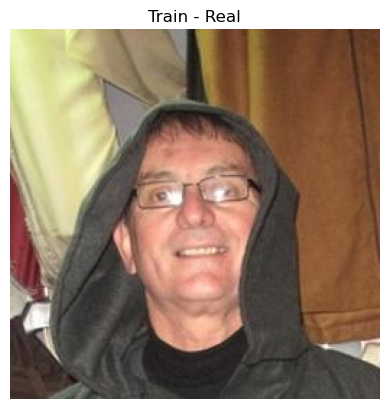

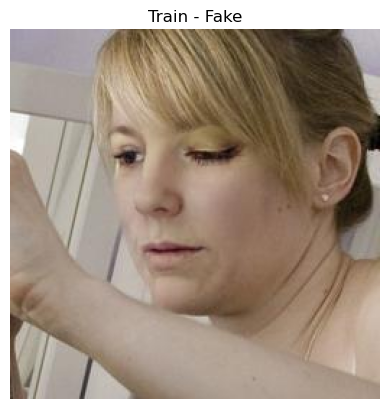

Displaying first images from Test directory:


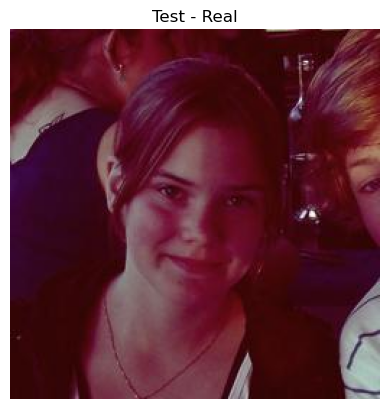

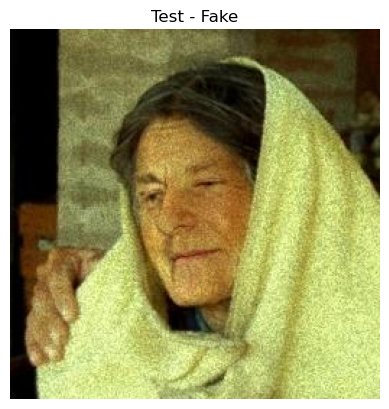

Displaying first images from Validation directory:


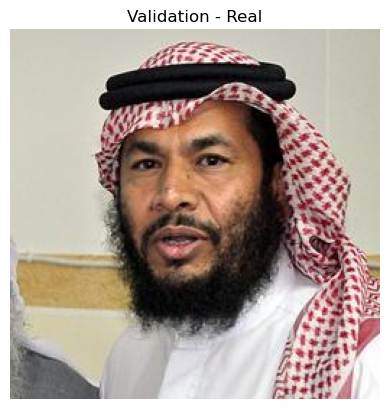

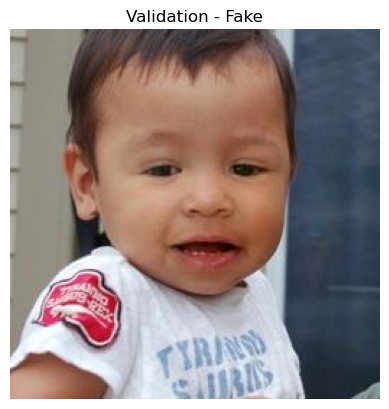

In [5]:
def displayFirst(directory, title):
    # Print name of directory for following 2 images
    print(f"Displaying first images from {title} directory:")
    for subfolder in ['Real', 'Fake']:
        subfolderpath = os.path.join(directory, subfolder)
        if os.path.exists(subfolderpath):
            files = os.listdir(subfolderpath)
            if files:
                first_image_path = os.path.join(subfolderpath, files[0])
                
                img = Image.open(first_image_path)
                plt.figure()
                plt.title(f"{title} - {subfolder}")
                plt.imshow(img)
                plt.axis('off')
                plt.show()


displayFirst(trainDirectory, "Train")
displayFirst(testDirectory, "Test")
displayFirst(validationDirectory, "Validation")

In [6]:
def countImages(directory):
    for subfolder in ['Real', 'Fake']:
        subfolderPath = os.path.join(directory, subfolder)
        if os.path.exists(subfolderPath):
            # Count up how many files are in subfolder
            nummberImages = len([file for file in os.listdir(subfolderPath) if os.path.isfile(os.path.join(subfolderPath, file))])
            print(f"Total amount of images in {subfolderPath}: {nummberImages}")


print("Counting images in the Train directory -->")
countImages(trainDirectory)


print("\nCounting images in the Test directory -->")
countImages(testDirectory)

print("\nCounting images in the Validation directory -->")
countImages(validationDirectory)

Counting images in the Train directory -->
Total amount of images in C:\Users\Evan\FYP\Train\Real: 70001
Total amount of images in C:\Users\Evan\FYP\Train\Fake: 70001

Counting images in the Test directory -->
Total amount of images in C:\Users\Evan\FYP\Test\Real: 5413
Total amount of images in C:\Users\Evan\FYP\Test\Fake: 5492

Counting images in the Validation directory -->
Total amount of images in C:\Users\Evan\FYP\Validation\Real: 19787
Total amount of images in C:\Users\Evan\FYP\Validation\Fake: 19641


## Model Imports

In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm  # For EfficientNetB5
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, f1_score

C:\Users\Evan\miniconda3\envs\fyp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Using GPU

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Using device: cuda


In [9]:
import os
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

# Set base path and construct absolute paths
baseDirectory = r"C:\Users\Evan\FYP"
newTrainDirectory = os.path.join(baseDirectory, "Train")
newValidationDirectory = os.path.join(baseDirectory, "Validation")
newTestDirectory = os.path.join(baseDirectory, "Test")

#Normalization values
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# https://pytorch.org/vision/stable/models.html#classification

#Filter dataset for supported files, good practise to do
def isValidImage(filePath):
    validExtensions = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')
    return filePath.lower().endswith(validExtensions) and '.ipynb_checkpoints' not in filePath


from torchvision.datasets import ImageFolder

def find_classes_no_dot(directory):
    classes = [entry.name for entry in os.scandir(directory) if entry.is_dir() and not entry.name.startswith('.')]
    classes.sort()
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx
    
# Extend ImageFolder to use the custom class-filtering logic as defined above
class CustomImageFolder(ImageFolder):
    def find_classes(self, directory):
        return find_classes_no_dot(directory)

newTrainDataset = CustomImageFolder(root=newTrainDirectory, transform=transform, is_valid_file=isValidImage)
newValidationDataset = CustomImageFolder(root=newValidationDirectory, transform=transform, is_valid_file=isValidImage)
newTestDataset = CustomImageFolder(root=newTestDirectory, transform=transform, is_valid_file=isValidImage)

# sizes for verification
print(f"\nNew Train dataset size: {len(newTrainDataset)}")
print(f"\nNew Test dataset size: {len(newTestDataset)}")
print(f"\nNew Validation dataset size: {len(newValidationDataset)}")

print(f"\nPlease check above dataset sizes and see that they match, if not, double check folders")





New Train dataset size: 140002

New Test dataset size: 10905

New Validation dataset size: 39428

Please check above dataset sizes and see that they match, if not, double check folders


### Dataloaders
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [10]:
batchSize = 32  # image batch size

# Setting num_workers=0 to avoid issues researched
newTrainLoader = DataLoader(newTrainDataset, batch_size=batchSize, shuffle=True, num_workers=0)
newValidationLoader = DataLoader(newValidationDataset, batch_size=batchSize, shuffle=False, num_workers=0)
newTestLoader = DataLoader(newTestDataset, batch_size=batchSize, shuffle=False, num_workers=0)

print("DataLoaders created with num_workers=0.")

# https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

DataLoaders created with num_workers=0.


### Load and Modify EfficientNetB5

In [11]:
# Load EfficientNetB5 with pre-trained weights from timm
model = timm.create_model('efficientnet_b5', pretrained=True)

os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1" # hides timm warnings


numFeatures = model.classifier.in_features  
model.classifier = nn.Linear(numFeatures, 2)  # Output logits for 2 classes


model = model.to(device)
print("Model loaded and modified.")


Model loaded and modified.


## Loss Function, Optimizer, and Scheduler

In [12]:
criterion = nn.CrossEntropyLoss()

# AdamW used for better generalisation
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

#https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html


# Learning rate decreases by 0.1 every 1 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
#https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html
print("Loss function, optimizer, and scheduler set.")


Loss function, optimizer, and scheduler set.


## Training and Validation Loop

In [13]:
from tqdm import tqdm  # Pip install in the enviroment, as I get errors and you will also if you dont

numEpochs = 5  # Adjust as I need
bestValF1 = 0.0  # To track the best validation F1 score

for epoch in range(numEpochs):
    # Training part
    model.train()
    trainLosses = []
    
    # Use tqdm to create a progress bar for the training loop
    pbar = tqdm(newTrainLoader, desc=f"Epoch {epoch+1}/{numEpochs} Training", unit="batch")
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        trainLosses.append(loss.item())
        
        # Update progress bar with the current loss
        pbar.set_postfix(loss=f"{loss.item():.4f}")
    
    avgTrainLoss = np.mean(trainLosses)
    
    # Validation part
    model.eval()
    valLosses = []
    allPreds = []
    allLabels = []
    
    with torch.no_grad(): # No gradient computation for memory
        for images, labels in newValidationLoader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            valLosses.append(loss.item())
            
            preds = torch.argmax(outputs, dim=1) # Gets predicted class from logits
            allPreds.extend(preds.cpu().numpy())
            allLabels.extend(labels.cpu().numpy())

    # Validation metrics within scikit-learn
    avgValLoss = np.mean(valLosses)
    valAccuracy = accuracy_score(allLabels, allPreds)
    valPrecision = precision_score(allLabels, allPreds, average='weighted')
    valF1 = f1_score(allLabels, allPreds, average='weighted')
    
    print(f"\nEpoch [{epoch+1}/{numEpochs}] Summary:")
    print(f"Train Loss: {avgTrainLoss:.4f}, Val Loss: {avgValLoss:.4f}")
    print(f"Val Acc: {valAccuracy:.4f}, Val Precision: {valPrecision:.4f}, Val F1: {valF1:.4f}")
    
    # Adjust learning rate with scheduler
    scheduler.step()

    torch.save(model.state_dict(), f'checkpoint_epoch_{epoch+1}.pth')
    
    # Save the model if the validation F1 improves
    if valF1 > bestValF1:
        bestValF1 = valF1
        torch.save(model.state_dict(), 'bestModel.pth')
        print(f"Best model saved at epoch {epoch+1} with F1: {valF1:.4f}")
        


Epoch 1/5 Training: 100%|████████████████████████████████████████| 4376/4376 [1:19:42<00:00,  1.09s/batch, loss=0.9537]



Epoch [1/5] Summary:
Train Loss: 0.0574, Val Loss: 0.0624
Val Acc: 0.9778, Val Precision: 0.9778, Val F1: 0.9778
Best model saved at epoch 1 with F1: 0.9778


Epoch 2/5 Training: 100%|████████████████████████████████████████| 4376/4376 [1:13:42<00:00,  1.01s/batch, loss=0.0001]



Epoch [2/5] Summary:
Train Loss: 0.0348, Val Loss: 0.1265
Val Acc: 0.9514, Val Precision: 0.9542, Val F1: 0.9513


Epoch 3/5 Training: 100%|████████████████████████████████████████| 4376/4376 [1:14:21<00:00,  1.02s/batch, loss=0.0013]



Epoch [3/5] Summary:
Train Loss: 0.0271, Val Loss: 0.0436
Val Acc: 0.9846, Val Precision: 0.9846, Val F1: 0.9846
Best model saved at epoch 3 with F1: 0.9846


Epoch 4/5 Training: 100%|████████████████████████████████████████| 4376/4376 [1:14:20<00:00,  1.02s/batch, loss=0.0000]



Epoch [4/5] Summary:
Train Loss: 0.0233, Val Loss: 0.0543
Val Acc: 0.9823, Val Precision: 0.9824, Val F1: 0.9823


Epoch 5/5 Training: 100%|████████████████████████████████████████| 4376/4376 [1:14:19<00:00,  1.02s/batch, loss=0.9545]



Epoch [5/5] Summary:
Train Loss: 0.0200, Val Loss: 0.0610
Val Acc: 0.9810, Val Precision: 0.9810, Val F1: 0.9810


In [20]:
import os
print(os.getcwd())
print(os.listdir(os.getcwd()))

#Done to check if model was created in the folder, just for peace of mind!


C:\Users\Evan\FYP
['.ipynb_checkpoints', 'bestModel.pth', 'Dataset', 'Generated Model', 'proto1.ipynb', 'Test', 'Train', 'Validation']


### Evaluate the Best Model on the Test Set

In [ ]:
# Load the best saved model from above
model.load_state_dict(torch.load('bestModel.pth', map_location=device))
model.eval()  # Set the model to evaluation mode
#https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.eval

allPreds = []
allLabels = []

# Progress bar
testPbar = tqdm(newTestLoader, desc="Testing", unit="batch")

with torch.no_grad(): # https://pytorch.org/docs/stable/generated/torch.no_grad.html
    for images, labels in testPbar:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1) # Convert logits our classes
        
        allPreds.extend(preds.cpu().numpy())
        allLabels.extend(labels.cpu().numpy())

# Calculate metrics for the test set
testAccuracy = accuracy_score(allLabels, allPreds)
testPrecision = precision_score(allLabels, allPreds, average='weighted')
testF1 = f1_score(allLabels, allPreds, average='weighted')

# Testing metrics discussed in report
print("Test Accuracy: {:.4f}".format(testAccuracy))
print("Test Precision: {:.4f}".format(testPrecision))
print("Test F1 Score: {:.4f}".format(testF1))
